# Building Intuition for Softmax, Log-Likelihood, and Cross Entropy

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline 
import copy
import os

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Add ndim property to tensors to allow plotting w/o converting to numpy
torch.Tensor.ndim = property(lambda x: len(x.shape))

# Save plots
plot_dir = "plots"

## Get MNIST dataset

In [0]:
from pathlib import Path
import requests
import pickle
import gzip


def get_data_mnist():
    """Get MNIST dataset, return as torch tensors"""
    
    # Download dataset
    URL = 'http://deeplearning.net/data/mnist/'
    FILENAME = 'mnist.pkl.gz'
    PATH = Path("data/mnist")  # save here
    PATH.mkdir(parents=True, exist_ok=True)
    if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open('wb').write(content)

    # Unzip, load pickled NumPy arrays, map to Torch tensors
    with gzip.open(PATH / FILENAME) as f:
        ((x_train, y_train), (x_valid, y_valid), 
         (x_test, y_test)) = pickle.load(f, encoding='latin-1')
    return map(torch.tensor, 
               (x_train, y_train, x_valid, y_valid, x_test, y_test))


x_train, y_train, x_valid, y_valid, x_test, y_test = get_data_mnist()

In [0]:
# Stats (shape, min, max, mean, std)
print(x_train.shape, y_train.shape, x_valid.shape, y_valid.shape, 
      x_test.shape, y_test.shape)
print(x_train.min(), x_train.max(), y_train.min(), y_train.max())
print(x_train.mean(), x_train.std())

torch.Size([50000, 784]) torch.Size([50000]) torch.Size([10000, 784]) torch.Size([10000]) torch.Size([10000, 784]) torch.Size([10000])
tensor(0.) tensor(0.9961) tensor(0) tensor(9)
tensor(0.1304) tensor(0.3073)


In [0]:
# Normalize. Get mean / std from training and apply to both train / valid sets


def normalize(x_data):
    """Normalize and also return stats (mean, std)"""
    m, s = x_data.mean(), x_data.std()
    return (x_data - m) / s, (m, s) 


def normalize_with(x_data, mean=None, std=None):
    """Normalize using given stats (mean, std). 
    If stats aren't provided, normalize with stats from input data
    """
    if not mean: mean = x_data.mean()
    if not std: std = x_data.std()
    return (x_data - mean) / std
    
    
x_train, (train_mean, train_std) = normalize(x_train)
x_valid = normalize_with(x_valid, mean=train_mean, std=train_std)


# Check normalization (min, max, mean, std)
print(x_train.min(), x_train.max(), y_train.min(), y_train.max())
print(x_train.mean(), x_train.std())
print(x_valid.mean(), x_valid.std())

tensor(-0.4244) tensor(2.8171) tensor(0) tensor(9)
tensor(0.0001) tensor(1.)
tensor(-0.0057) tensor(0.9924)


tensor(5)

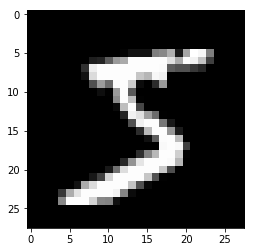

In [0]:
# Preview data
img = x_train[0].view(28, 28)
plt.imshow(img, cmap="gray"); y_train[0]

In [0]:
# Setup data loader to feed training loop

class Dataset():
    """Combine input and labels"""
    def __init__(self, x, y):
        self.x, self.y = x, y
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, i):
        return self.x[i], self.y[i]
    
    
def make_dataloader(x_data, y_data, bs, shuffle=False):
    """Make DataLoaders given batch size"""
    dataset = Dataset(x_data, y_data)
    return DataLoader(dataset, bs, shuffle)

## Train a model on MNIST

In [0]:
# Simple network with single hidden layer
n_in = x_train.shape[1]
n_out = 10  # classes

def get_model(nh=50):
    """Single hidden layer"""
    return nn.Sequential(nn.Linear(n_in, nh), nn.ReLU(), nn.Linear(nh, n_out))

In [0]:
loss_func = F.cross_entropy  # log softmax + negative log likelihood


def accuracy(out, yb):
    """Categorical accuracy: Does class with highest value match target?"""
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()


def train(epochs, model, loss_func, opt, bs, train_dl, valid_dl):
    """Train model. Return validation loss, accuracy"""
    nb = len(train_dl)
    model = model.to(device)
    for epoch in range(epochs):
        # Training batches
        model.train()  # training
        tot_loss_trn, tot_acc_trn = 0., 0.
        for xb, yb in train_dl:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            loss = loss_func(pred, yb)
            tot_loss_trn += loss  # accumulate and divide by batches each epoch
            tot_acc_trn += accuracy(pred, yb)
            loss.backward()  # get gradients
            opt.step()
            opt.zero_grad()
        
        # Validation batches
        tot_loss, tot_acc, nb_val = 0., 0., 1.
        if valid_dl:
            nb_val = len(valid_dl)
            model.eval()  # validation
            with torch.no_grad():
                for xb, yb in valid_dl:
                    xb, yb = xb.to(device), yb.to(device)
                    pred = model(xb)
                    tot_loss += loss_func(pred, yb)
                    tot_acc += accuracy(pred, yb)
                    
        # Epoch status
        if not epoch or (epoch % 1 == 0): 
            print(f"Epoch: {epoch:3d}, "
                  f"Loss (train / val): "
                  f"{tot_loss_trn / nb:.7f} / {tot_loss / nb_val:.7f}, "
                  f"Acc: {tot_acc / nb_val:.4f}")
     
    # Return last epoch validation loss & acc
    return tot_loss / nb_val, tot_acc / nb_val 


model = get_model(nh=50)
opt = torch.optim.SGD(model.parameters(), lr=0.2)

bs = 64
train_dl = make_dataloader(x_train, y_train, bs, shuffle=True)
valid_dl = make_dataloader(x_valid, y_valid, bs * 2, shuffle=False)

# Make a copy of the untrained model
model_untrained = copy.deepcopy(model)

# Train
epochs = 5
train(epochs, model, loss_func, opt, bs, train_dl, valid_dl)

Epoch:   0, Loss (train / val): 0.2654204 / 0.1487712, Acc: 0.9558
Epoch:   1, Loss (train / val): 0.1278152 / 0.1101677, Acc: 0.9686
Epoch:   2, Loss (train / val): 0.0976174 / 0.1211238, Acc: 0.9636
Epoch:   3, Loss (train / val): 0.0776975 / 0.1165681, Acc: 0.9659
Epoch:   4, Loss (train / val): 0.0668325 / 0.0995720, Acc: 0.9727


(tensor(0.0996), tensor(0.9727))

## Visualize raw outputs from network

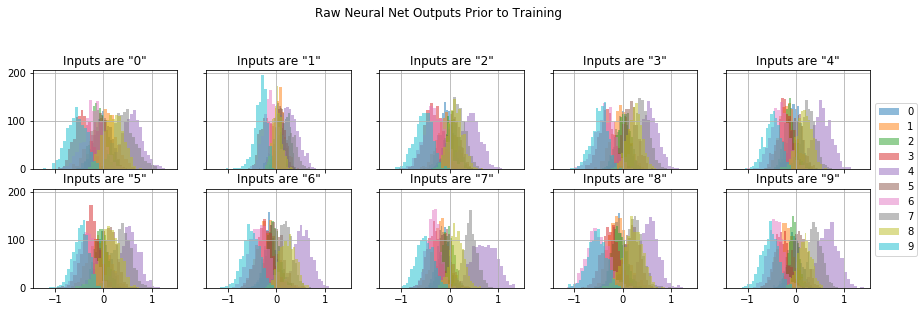

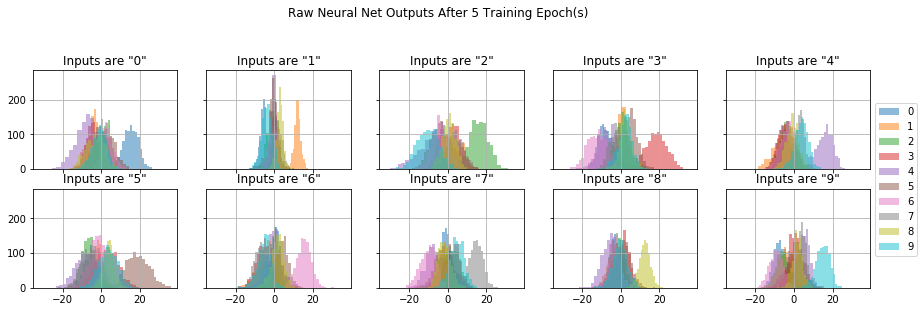

In [0]:
# Visualize distribution of network outputs across input class


def get_idxs(labels, target):
    """Return indices of labels matching target"""
    return (labels == target).nonzero().squeeze_(-1)


def sample_one_class(x_data, y_data, label, size):
    """Sample dataset of specific class"""
    targ_idxs = get_idxs(y_data, label)  # get all idxs with this label
    size = min(size, get_idxs(y_data, label).shape[0])  # get subset
    idxs = np.random.choice(targ_idxs, size=size, replace=False) 
    return x_data[idxs], y_data[idxs]


def plot_output_dist(model, x_data, y_data, n_samples=1000, labels=None, 
                     bins=20):
    """Plot network output distribution given specific input class"""
    
    if not labels: labels = sorted(set(y_data.numpy()))
    nc = min(5, len(labels))
    nr = int(np.ceil(len(labels) / nc))
    fig, axes = plt.subplots(nr, nc, figsize=(3*nc, 2*nr), 
                             sharex=True, sharey=True)
    
    model.eval(), model.to(device)
    with torch.no_grad():
        for ax, label in zip(axes.flatten(), labels):  # each input class
            xs, ys = sample_one_class(x_data, y_data, label, size=n_samples)
            outp = model(xs.to(device)).cpu()
            for i in range(outp.shape[1]):  # each output node
                ax.hist(outp[:, i], alpha=0.5, label=i, bins=bins)
                ax.set_title(f'Inputs are "{label}"')
                ax.grid(True)
    ax.legend(loc='center left', bbox_to_anchor=(1, 1.1));
    return fig, axes
    
    
def save_fig(fig, filename, folder=None):
    """Save fig to filename in folder (optional)"""
    if not folder:
        fname = filename
    else:  
        if not os.path.exists(folder):
            os.makedirs(folder)
        fname = folder + os.sep + filename
    fig.savefig(fname)
    
    
n_samples = 1000
fig, axes = plot_output_dist(model_untrained, x_train, y_train, n_samples)
fig.suptitle("Raw Neural Net Outputs Prior to Training", y=1.1);
save_fig(fig, "raw_outputs_untrained.png", plot_dir)

fig, axes = plot_output_dist(model, x_train, y_train, n_samples)
fig.suptitle(f"Raw Neural Net Outputs After {epochs} Training Epoch(s)", y=1.1);
save_fig(fig, "raw_outputs_trained.png", plot_dir)

## Get probabilities with Softmax
Maps raw network output vector to a probability distribution using the softmax function. 

Mathematically, softmax is defined as follows. For raw network outputs across $C$ classes $\mathbf{x} = (x_1, ..., x_C) \in \mathbb{R}^C$ and class $i = 1, ..., C$,

$$
\text{softmax}(\mathbf{x})_i = \frac{e^{x_i}}{\sum_{j=1}^C e^{x_j}} 
$$

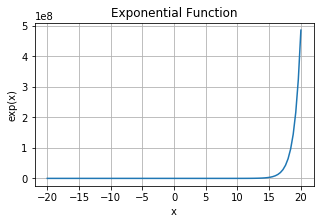

In [0]:
# Visualize exponential function
x = np.linspace(-20, 20, 100)

fig, ax = plt.subplots(figsize=(5,3))
ax.plot(x, np.exp(x))
ax.set_xlabel("x")
ax.set_ylabel("exp(x)")
ax.set_title("Exponential Function")
ax.grid(True);
save_fig(fig, "exp.png", plot_dir)

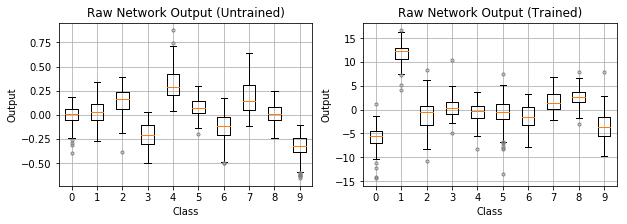

In [0]:
# How do we go from the raw network output to making a prediction?
# How do we gauge how far our prediction is from the target?

# Sample image batch of a common class
n_samples = 128
xs, ys = sample_one_class(x_train, y_train, label=1, size=n_samples)
model.eval()
with torch.no_grad():
    outp = model(xs.to(device)).cpu()
    outp_untrained = model_untrained(xs.to(device)).cpu()
        
    
def plot_box_multi(data_list, titles=None, yscales=None, axsize=(5,3), 
                   sharey=False):
    def listify(x): return [x] if not isinstance(x, list) else x
    cols = len(listify(data_list))
    flierprops = dict(marker='o', markersize=3, markeredgecolor='gray')
    
    fig, axes = plt.subplots(1, cols, figsize=(axsize[0]*cols, axsize[1]), 
                             sharey=sharey)
    if not isinstance(axes, np.ndarray): axes = [axes]  # single axes
    for i, (data, ax) in enumerate(zip(listify(data_list), axes)): 
        ax.grid(True)
        ax.set_xlabel("Class")
        ax.set_ylabel("Output")
        ax.boxplot(data.numpy(), flierprops=flierprops, labels=range(10))
        if titles: ax.set_title(listify(titles)[i])
        if yscales and listify(yscales)[i]=='log': ax.set_yscale('log')
    return fig, axes


def plot_hist_multi(data_list, titles=None, xscales=None, axsize=(5,3), 
                    sharex=False):
    def listify(x): return [x] if not isinstance(x, list) else x
    cols = len(listify(data_list))
    flierprops = dict(marker='o', markersize=3, markeredgecolor='gray')
    
    fig, axes = plt.subplots(1, cols, figsize=(axsize[0]*cols, axsize[1]), 
                             sharex=sharex)
    if not isinstance(axes, np.ndarray): axes = [axes]  # single axes
    for i, (data, ax) in enumerate(zip(listify(data_list), axes)): 
        ax.grid(True)
        ax.set_xlabel("Output")
        ax.set_ylabel("Count")
        for c in range(outp.shape[1]):  # each output node
            ax.hist(data[:, c], alpha=0.5, label=c, bins=20)
        ax.grid(True)
        if titles: ax.set_title(listify(titles)[i])
        if xscales and listify(xscales)[i]=='log': ax.set_xscale('log')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));
    return fig, axes


data_list = [outp_untrained, outp]
titles = ["Raw Network Output (Untrained)", "Raw Network Output (Trained)"]
plot_box_multi(data_list, titles, sharey=False);

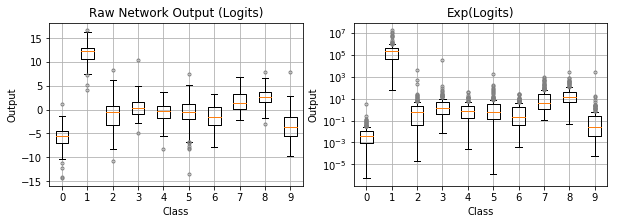

In [0]:
# What do the exponentials of the raw outputs look like?
exps = outp.exp()

data_list = [outp, exps]
titles = ["Raw Network Output (Logits)", "Exp(Logits)"]
plot_box_multi(data_list, titles, yscales=['','log']);

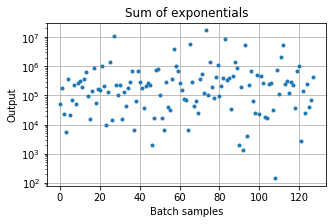

In [0]:
def plot_batch_multi(data_list, titles=None, yscales=None, axsize=(5,3),
                     sharey=False):
    def listify(x): return [x] if not isinstance(x, list) else x
    cols = len(listify(data_list))
#     flierprops = dict(marker='o', markersize=3, markeredgecolor='gray')
    
    fig, axes = plt.subplots(1, cols, figsize=(axsize[0]*cols, axsize[1]), 
                             sharey=sharey)
    if not isinstance(axes, np.ndarray): axes = [axes]  # single axes
    for i, (data, ax) in enumerate(zip(listify(data_list), axes)): 
        ax.grid(True)
        ax.set_xlabel("Batch samples")
        ax.set_ylabel("Output")
        ax.plot(data, '.')
        if titles: ax.set_title(listify(titles)[i])
        if yscales and listify(yscales)[i]=='log': ax.set_yscale('log')
    return fig, axes
        
# What do the sums of the exponentials look like?
sum_exps = outp.exp().sum(dim=-1, keepdim=True)  # sum across classes
plot_batch_multi(sum_exps, titles="Sum of exponentials", yscales="log");

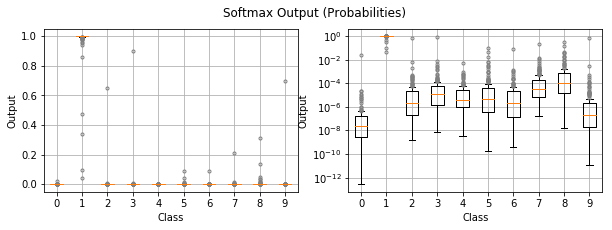

In [0]:
# What do the softmax outputs (probabilities) look like?
probs = exps / sum_exps

fig, _ = plot_box_multi([probs, probs], yscales=['','log'])
fig.suptitle("Softmax Output (Probabilities)");

In [0]:
def softmax(logits):
    """Map raw network output vector to probabilities using softmax function"""
    return logits.exp() / logits.exp().sum(-1, keepdim=True)

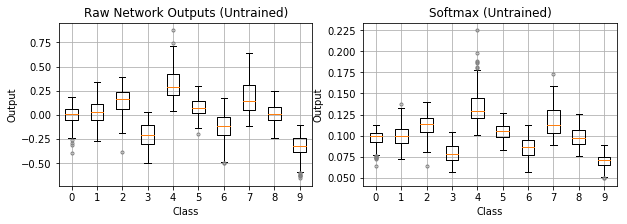

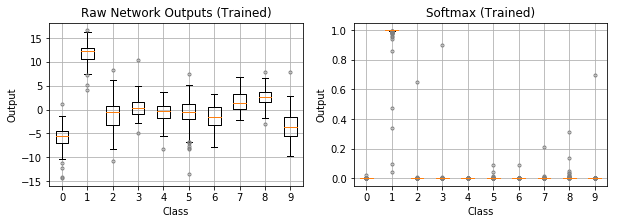

In [0]:
# Show progression from raw outputs to softmax for untrained and trained
data_list = [outp_untrained, softmax(outp_untrained)]
titles = ["Raw Network Outputs (Untrained)", "Softmax (Untrained)"]
fig, _ = plot_box_multi(data_list, titles);
save_fig(fig, "softmax_untrained.png", plot_dir)

data_list = [outp, softmax(outp)]
titles = ["Raw Network Outputs (Trained)", "Softmax (Trained)"]
fig, _ = plot_box_multi(data_list, titles);
save_fig(fig, "softmax_trained.png", plot_dir)

In [0]:
assert (abs(probs.sum(1) - 1) < 1e-4).all(), "Probabilities don't sum to 1."

## Log probabilities

Use "negative" because most optimizers minimize rather than maximize a loss function. Minimize a negative likelihood is equivalent to maximizing a likelihood.


**Why take the log?**
- Logarithms are monotonic, so optimizing the log of a function is the same optimizing the function itself.
- Logarithm helps with numerical stability for our finite precision computers. They converting very small positive values to larger negative values, reducing potential for underflow from small likelihood values.
- Multiplications become sums and divisions become subtractions.

[https://stats.stackexchange.com/questions/141087/i-am-wondering-why-we-use-negative-log-likelihood-sometimes](https://stats.stackexchange.com/questions/141087/i-am-wondering-why-we-use-negative-log-likelihood-sometimes)




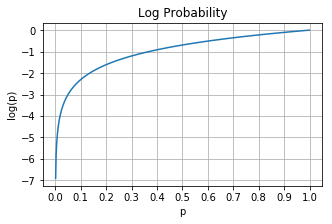

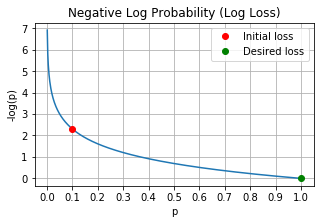

In [0]:
# What does the log transform do? Specifically to very small positive values?
x = np.linspace(0.001, 0.999, 999)

fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(x, np.log(x))
ax.set_xticks(np.linspace(0,1,11))
ax.grid(True)
ax.set_xlabel("p")
ax.set_ylabel("log(p)")
ax.set_title("Log Probability");
save_fig(fig, "log.png", plot_dir)

fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(x, -np.log(x))
ax.plot(0.1, -np.log(0.1), 'ro', label="Initial loss" )
ax.plot(1.0, -np.log(1.0), 'go', label="Desired loss")
ax.grid(True)
ax.set_xticks(np.linspace(0,1,11))
ax.set_xlabel("p")
ax.set_ylabel("-log(p)")
ax.set_title("Negative Log Probability (Log Loss)")
ax.legend();
save_fig(fig, "neg_log_annot.png", plot_dir)

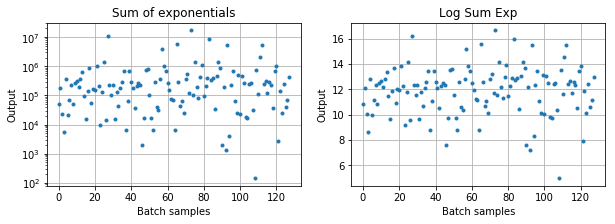

In [0]:
# What does the log of the sum of exponentials look like?
lse = outp.exp().sum(-1, keepdim=True).log()  # not numerically  stabilized
titles = ["Sum of exponentials", "Log Sum Exp"]
plot_batch_multi([sum_exps, lse], titles, yscales=['log','']);

In [0]:
def logsumexp(logits):
    """Log sum exp, numerically stabilized by extracting max from ops"""
    max_c = logits.max(-1)[0]
    return max_c + (logits - max_c[:, None]).exp().sum(-1).log()

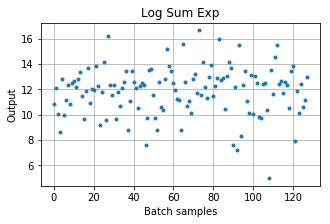

In [0]:
plot_batch_multi(logsumexp(outp), "Log Sum Exp");

In [0]:
def log_softmax(logits):
    """Log softmax. Log sum exp op numerically stabilized by extracting max."""
    max_c = logits.max(-1)[0]
    logsumexp =  max_c + (logits - max_c[:, None]).exp().sum(-1).log()
    return logits - logsumexp.unsqueeze(-1)

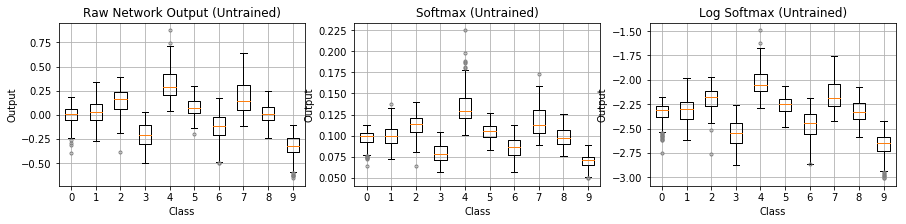

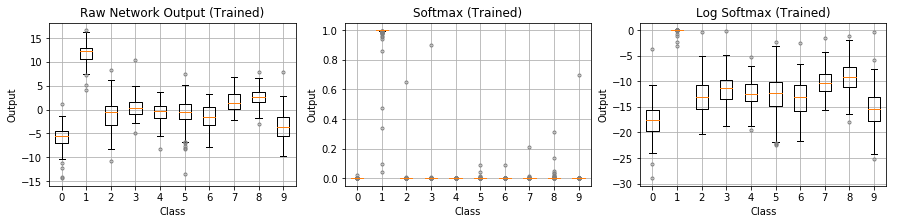

In [0]:
# Show progression from raw outputs to softmax to log softmax 
# for untrained and trained
titles = ['Raw Network Output (Untrained)', 'Softmax (Untrained)', 
          'Log Softmax (Untrained)']
data_list = [outp_untrained, softmax(outp_untrained), log_softmax(outp_untrained)]
fig, _ = plot_box_multi(data_list, titles, yscales=['','','']);
save_fig(fig, "logsoftmax_untrained.png", plot_dir)

titles = ['Raw Network Output (Trained)', 'Softmax (Trained)', 'Log Softmax (Trained)']
data_list = [outp, softmax(outp), log_softmax(outp)]
fig, _ = plot_box_multi(data_list, titles, yscales=['','','']);
save_fig(fig, "logsoftmax_trained.png", plot_dir)

## Negative log-likelihood and cross entropy loss

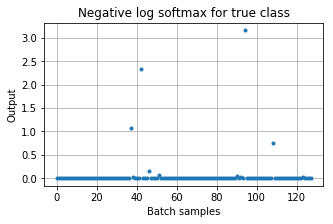

In [0]:
lsm = log_softmax(outp)
targ_nlsm = -lsm[range(lsm.shape[0]), ys]  # Output values for target class 
plot_batch_multi(targ_nlsm, f"Negative log softmax for true class");

In [0]:
-lsm[range(lsm.shape[0]), ys].mean()  # batch average (nll)

tensor(0.0616)

In [0]:
def nll_loss(inp, targ):
    """Negative log likelihood loss
    
    Takes in log softmax and returns negative batch average over true class 
    values.
    """
    return -inp[range(inp.shape[0]), targ].mean()

In [0]:
nll_loss(lsm, ys)

tensor(0.0616)

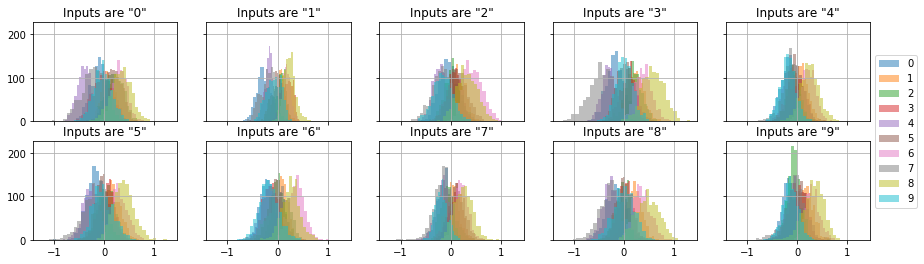

In [0]:
# Network outputs prior to training
model = get_model()
opt = torch.optim.SGD(model.parameters(), lr=0.2)
plot_output_dist(model, x_train, y_train, n_samples=1000);

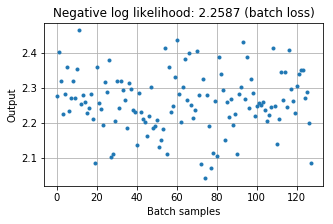

In [0]:
# Prior to training, what do the losses look like?
n_sp = 128
xs, ys = sample_one_class(x_train, y_train, label=1, size=n_sp)
model.eval(), model.to(device)
with torch.no_grad():
    outp = model(xs.to(device)).cpu()
    lsm = log_softmax(outp)  
    targ_nlsm = -lsm[range(lsm.shape[0]), ys]

nll = nll_loss(lsm, ys)
plot_batch_multi(targ_nlsm, f"Negative log likelihood: {nll:.4f} (batch loss)");

# Save for comparison
nll_notrain = nll
targ_nlsm_notrain = targ_nlsm

In [0]:
assert abs(F.cross_entropy(outp, ys) - nll) < 1e-4, \
    "Should match PyTorch's cross entropy loss"

In [0]:
train(5, model, loss_func, opt, bs, train_dl, valid_dl)

Epoch:   0, Loss (train / val): 0.2678295 / 0.1786634, Acc: 0.9417
Epoch:   1, Loss (train / val): 0.1236635 / 0.1283751, Acc: 0.9625
Epoch:   2, Loss (train / val): 0.0941607 / 0.1033962, Acc: 0.9708
Epoch:   3, Loss (train / val): 0.0770131 / 0.1100982, Acc: 0.9694
Epoch:   4, Loss (train / val): 0.0658112 / 0.1044204, Acc: 0.9712


(tensor(0.1044), tensor(0.9712))

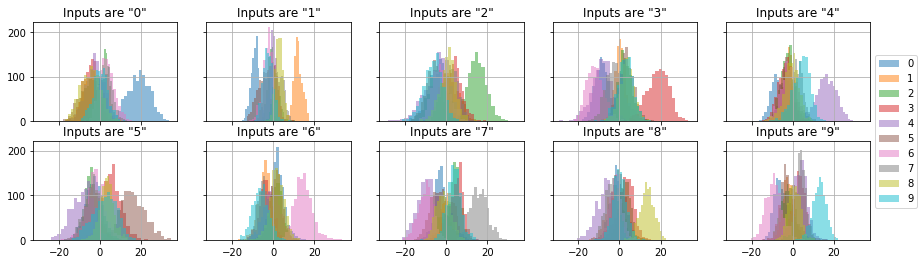

In [0]:
# Visualize network output after training
plot_output_dist(model, x_train, y_train, n_samples=1000);

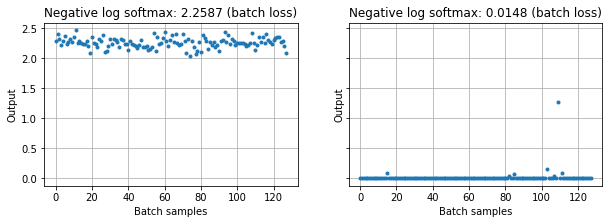

In [0]:
# After training, what do the losses look like?
model.eval(), model.to(device)
with torch.no_grad():
    outp = model(xs.to(device)).cpu()
    
lsm = log_softmax(outp)  
targ_nlsm = -lsm[range(lsm.shape[0]), ys]
nll = nll_loss(lsm, ys)

# Visualize losses before and after trainining
data_list = [targ_nlsm_notrain, targ_nlsm]
titles = [f"Negative log softmax: {nll_notrain:.4f} (batch loss)", 
          f"Negative log softmax: {nll:.4f} (batch loss)"]
fig, _ = plot_batch_multi(data_list, titles, sharey=True);
save_fig(fig, "losses_before_after.png", plot_dir)

In [0]:
assert abs(F.cross_entropy(outp, ys) - nll) < 1e-4, \
    "Should match PyTorch's cross entropy loss"

## Examine high loss inputs

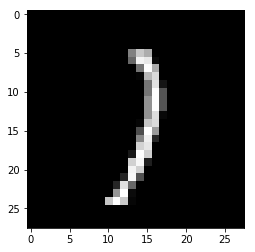

In [0]:
# Examine high loss images (expect these to be harder to classify)
loss_threshold = 0.25
high_loss_idxs = np.argwhere(targ_nlsm.numpy() > loss_threshold).squeeze(-1)

for i in high_loss_idxs:
    plt.figure()
    plt.imshow(xs[i].view(28, 28), cmap="gray")